In [ ]:
#hide
from utils import *
from IPython.display import display,HTML

# NLP deep dive: RNNs

In <<chapter_intro>> we saw that deep learning can be used to get great results with natural language datasets. Our example relied on using a pretrained language model and fine-tuning it to classify those reviews. One thing is a bit different from the transfer learning we have in computer vision: the pretrained model was not trained on the same task as the model we used to classify reviews.

What we call a language model is a model that has been trained to guess what the next word in a text is (having read the ones before). This kind of task is called *self-supervised learning*: we do not need to give labels to our model, just feed it lots and lots of texts. It has a process to automatically get labels from the data, and this task isn't trivial: to properly guess the next word in a sentence, the model will have to get an understanding of the English-- or other--language. Self-supervised learning can also be used in other domains; for instance, see [Self-supervised learning and computer vision](https://www.fast.ai/2020/01/13/self_supervised/) for an introduction to vision applications. Self-supervised learning is not usually used for the model that is trained directly, but instead is used for pre-training a model used for transfer learning.

> jargon: Self-supervised learning: Training a model using labels that are embedded in the independent variable, rather than requiring external labels. For instance, training a model to predict the next word in a text.

The language model we used in <<chapter_intro>> to classify IMDb reviews was pretrained on Wikipedia. We got great results by directly fine-tuning this language model to a movie review classifier, but with one extra step, we can do even better: the Wikipedia English is slightly different from the IMDb English. So instead of jumping directly to the classifier, we could finetune our pretrained language model to the IMDb corpus and *then* use that as the base for our classifier.

Even if our language model knows the basics of the language we are using in the task (e.g., our pretrained model is in English), it helps to get used to the style of the corpus we are targetting. It may be more informal language, or more technical, with new words to learn or different ways of composing sentences. In the case of IMDb, there will be lots of names of movie directors and actors, and often a less formal style of language that seen in Wikipedia.

We saw that with fastai, we can download a pre-trained language model for English, and use it to get state-of-the-art results for NLP classification. (We expect pre-trained models in many more languages to be available soon — they might well be available by the time you are reading this book, in fact.) So, why are we learning how to train a language model in detail?

One reason, of course, is that it is helpful to understand the foundations of the models that you are using. But there is another very practical reason, which is that you get even better results if you fine tune the (sequence-based) language model prior to fine tuning the classification model. For instance, for the IMDb sentiment analysis task, the dataset includes 50,000 additional movie reviews that do not have any positive or negative labels attached. So that is 100,000 movie reviews altogether (since there are also 25,000 labelled reviews in the training set, and 25,000 in the validation set). We can use all 100,000 of these reviews to fine tune the pretrained language model — this will result in a language model that is particularly good at predicting the next word of a movie review. In contrast, the pretrained model was trained only on Wikipedia articles.

The [ULMFiT paper](https://arxiv.org/abs/1801.06146) showed that this extra stage of language model fine tuning, prior to transfer learning to a classification task, resulted in significantly better predictions. Using this approach, we have three stages for transfer learning in NLP, as summarised in <<ulmfit_process>>.

<img alt="Diagram of the ULMFiT process" width="700" caption="The ULMFiT process" id="ulmfit_process" src="images/att_00027.png">

Now have a think about how you would turn this language modelling problem into a neural network, given what you have learned so far. We'll be able to use concepts that we've seen in the last two chapters.

## Text preprocessing

It's not at all obvious how we're going to use what we've learned so far to build a language model. Sentences can be different lengths, and documents can be very long. So, how can we predict the next word of a sentence using a neural network? Let's find out!

We've already seen how categorical variables can be used as independent variables for a neural network. The approach we took for a single categorical variable was to:

1. Make a list of all possible levels of that categorical variable (let us call this list the *vocab*)
1. Replace each level with its index in the vocab
1. Create an embedding matrix for this containing a row for each level (i..e, for each item of the vocab)
1. Use this embedding matrix as the first layer of a neural network. (A dedicated embedding matrix can take as inputs the raw vocab indexes created in step two; this is equivalent to, but faster and more efficient, than a matrix which takes as input one-hot encoded vectors representing the indexes)

We can do nearly the same thing with text! What is new is the idea of a sequence. First we concatenate all of the documents in our dataset into one big long string and split it into words, giving us a very long list of words. Our independent variable will be the sequence of words starting with the first word in our very long list and ending with the second last, and our dependent variable would be the sequence of words starting with the second word and ending with the last word. 

When creating our vocab, we will have very common words that will probably be in the vocabulary of our pretrained model, but we will also have new words specific to our corpus (cinematographic terms, or actor names for instance). Our embedding matrix will be built accordingly: for words that are in the vocabulary of our pretrained model, we will take the corresponding row in the embedding matrix of this pretrained model; but for new words, we won't have anything, so we will just initialize the corresponding row with a random vector.

Each of the steps necessary to create a language model has jargon associated with it from the world of natural language processing, and fastai and PyTorch classes available to help. The steps are:

- **Tokenization**:: convert the text into a list of words (or characters, or substrings, depending on the granularity of your model)
- **Numericalization**:: make a list of all of the unique words which appear (the vocab), and convert each word into a number, by looking up its index in the vocab
- **Language model data loader** creation:: fastai provides an `LMDataLoader` class which automatically handles creating a dependent variable which is offset from the independent variable buy one token. It also handles some important details, such as how to shuffle the training data in such a way that the dependent and independent variables maintain their structure as required
- **Language model** creation:: we need a special kind of model which does something we haven't seen before: handles input lists which could be arbitrarily big or small. There are a number of ways to do this; in this chapter we will be using a *recurrent neural network*. We will get to the details of this in the <<chapter_nlp_dive>>, but for now, you can think of it as just another deep neural network.

Let's take a look at how each step works in detail.

### Tokenization

When we said, *convert the text into a list of words*, we left out a lot of details. For instance, what do we do with punctuation? How do we deal with a word like "don't"? Is it one word, or two? What about long medical or chemical words? Should they be split into their separate pieces of meaning? How about hyphenated words? What about languages like German and Poland where we can create really long words from many, many pieces? What about languages like Japanese and Chinese which don't use bases at all, and don't really have a well-defined idea of *word*?

Because there is no one correct answer to these questions, there is no one approach to tokenization. Each element of the list created by the tokenisation process is called a *token*. There are three main approaches:

- **Word-based**:: split a sentence on spaces, as well as applying language specific rules to try to separate parts of meaning, even when there are no spaces, such as turning "don't" into "do n't". Generally, punctuation marks are also split into separate tokens
- **Subword based**:: split words into smaller parts, based on the most commonly occurring substrings. For instance, "occasion" might be tokeniser as "o c ca sion"
- **Character-based**:: split a sentence into its individual characters.

We'll be looking at word and subword tokenization here, and we'll leave character-based tokenization for you to implement in the questionnaire at the end of this chapter.

> jargon: token: one element of a list created by the tokenisation process. It could be a word, part of a word (a _subword_), or a single character.

### Word tokenization with fastai

Rather than providing its own tokenizers, fastai instead provides a consistent interface to a range of tokenisers in external libraries. Tokenization is an active field of research, and new and improved tokenizers are coming out all the time, so the defaults that fastai uses change too. However, the API and options shouldn't change too much, since fastai tries to maintain a consistent API even as the underlying technology changes.

Let's try it out with the IMDb dataset that we used in <<chapter_intro>>:

In [ ]:
from fastai2.text.all import *
path = untar_data(URLs.IMDB)

We'll need to grab the text files in order to try out a tokenizer. Just like `get_image_files`, which we've used many times already, gets all the image files in a path, `get_text_files` gets all the text files in a path. We can also optionally pass `folders` to restrict the search to a particular list of subfolders:

In [ ]:
files = get_text_files(path, folders = ['train', 'test', 'unsup'])

Here's a review that we'll tokenize (we'll just print the start of it here to save space):

In [ ]:
txt = files[0].open().read(); txt[:75]

'This movie, which I just discovered at the video store, has apparently sit '

As we write this book, the default *English word tokenizer* for fastai uses a library called *spaCy*. This uses a sophisticated rules engine that has special rules for URLs, individual special English words, and much more. Rather than directly using `SpacyTokenizer`, however, we'll use `WordTokenizer`, since that will always point to fastai's current default word tokenizer (which may not always be Spacy, depending when you're reading this).

Let's try it out. We'll use fastai's `coll_repr(collection,n)` function to display the results; this displays the first `n` items of `collection`, along with the full size--it's what `L` uses by default. Not that fastai's tokenizers take a collection of documents to tokenize, so we have to wrap `txt` in a list:

In [ ]:
spacy = WordTokenizer()
toks = first(spacy([txt]))
print(coll_repr(toks, 30))

(#201) ['This','movie',',','which','I','just','discovered','at','the','video','store',',','has','apparently','sit','around','for','a','couple','of','years','without','a','distributor','.','It',"'s",'easy','to','see'...]


As you see, spaCy has mainly just separated out the words and punctuation. But it does something else here too: it has split "it's" into "it" and "'s". That makes intuitive sense--these are separate words, really. Tokenization is a surprisingly subtle task, when you think about all the little details that have to be handled. spaCy handles these for us, for instance, here we see that "." is separated when it terminates a sentence, but not in an acronym or number:

In [ ]:
first(spacy(['The U.S. dollar $1 is $1.00.']))

(#9) ['The','U.S.','dollar','$','1','is','$','1.00','.']

fastai then adds some additional functionality to the tokenization process with the `Tokenizer` class:

In [ ]:
tkn = Tokenizer(spacy)
print(coll_repr(tkn(txt), 31))

(#228) ['xxbos','xxmaj','this','movie',',','which','i','just','discovered','at','the','video','store',',','has','apparently','sit','around','for','a','couple','of','years','without','a','distributor','.','xxmaj','it',"'s",'easy'...]


There are now some tokens added that start with the characters "xx", which is not a common word prefix in English. These are *special tokens*.

For example, the first item in the list, "xxbos", is a special token that indicates the start of a new text ("BOS" is a standard NLP acronym which means "beginning of stream"). By recognizing this start token, the model will be able to learn it needs to "forget" what was said previously and focus on upcoming words.

These special tokens don't come from spaCy directly. They are there because fastai adds them by default, by applying a number of rules when processing text. These rules are designed to make it easier for a model to recognise the important parts of a sentence. In a sense, we are translating the original English language sequence into a simplified tokenised language, a language which is designed to be easy for a model to learn.

For instance, the rules will replace a sequence of four exclamation points with a single exclamation point, followed by a special *repeated character* token, and then the number four. In this way, the model's embedding matrix can encode information about general concepts such as repeated punctuation rather than requiring a separate token for every number of repetitions of every punctuation mark. Similarly, a capitalised word will be replaced with a special capitalisation token, followed by the lower case version of the word. This way, the embedding matrix only needs the lower case version of the words, saving compute and memory, but can still learn the concept of capitalisation.

Here are some of the main special tokens you'll see:

- xxbos:: indicates the beginning of a text (here a review)
- xxmaj:: indicates the next word begins with a capital (since we lower-cased everything)
- xxunk:: indicates the next word is unknown

To see the rules that were used, you can check the default rules:

In [ ]:
defaults.text_proc_rules

[<function fastai2.text.core.fix_html(x)>,
 <function fastai2.text.core.replace_rep(t)>,
 <function fastai2.text.core.replace_wrep(t)>,
 <function fastai2.text.core.spec_add_spaces(t)>,
 <function fastai2.text.core.rm_useless_spaces(t)>,
 <function fastai2.text.core.replace_all_caps(t)>,
 <function fastai2.text.core.replace_maj(t)>,
 <function fastai2.text.core.lowercase(t, add_bos=True, add_eos=False)>]

As always, you can look at the source code of each of them in a notebook by typing

```
??replace_rep
```

Here is a brief summary of what each does:

- `fix_html`:: replace special HTML characters by a readable version (IMDb reviwes have quite a few of them for instance) ;
- `replace_rep`:: replace any character repeated three times or more by a special token for repetition (xxrep), the number of times it's repeated, then the character ;
- `replace_wrep`:: replace any word repeated three times or more by a special token for word repetition (xxwrep), the number of times it's repeated, then the word ;
- `spec_add_spaces`:: add spaces around / and # ;
- `rm_useless_spaces`:: remove all repetitions of the space character ;
- `replace_all_caps`:: lowercase a word written in all caps and adds a special token for all caps (xxcap) in front of it ;
- `replace_maj`:: lowercase a capitalized word and adds a special token for capitalized (xxmaj) in front of it ;
- `lowercase`:: lowercase all text and adds a special token at the beginning (xxbos) and/or the end (xxeos).

Let's take a look at a few of them in action:

In [ ]:
coll_repr(tkn('&copy;   Fast.ai www.fast.ai/INDEX'), 31)

"(#11) ['xxbos','©','xxmaj','fast.ai','xxrep','3','w','.fast.ai','/','xxup','index'...]"

Now let's have a look at how subword tokenization would work.

### Subword tokenization

In addition to the *word tokenization* approach seen in the last section, another popular tokenization method is *subword tokenization*. Word tokenization relies on an assumption that spaces provide a useful separation of components of meaning in a sentence. However, this assumption is not always appropriate. For instance, consider this sentence: 我的名字是郝杰瑞 (which means "My name is Jeremy Howard" in Chinese). That's not going to work very well with a word tokenizer, because there are no spaces in it! Languages like Chinese and Japanese don't use spaces, and in fact they don't even have a well-defined concept of a "word". There are also languages, like Turkish and Hungarian, which can add many bits together without spaces, to create very long words which include a lot of separate pieces of information.

To handle these cases, it's generally best to use subword tokenization. This proceeds in two steps:

1. Analyze a corpus of documents to find the most commonly occurring groups of letters. These become the vocab.
2. Tokenize the corpus using this vocab of *subword units*.

Let's look at an example. For our corpus, we'll use the first 2000 movie reviews:

In [ ]:
txts = L(o.open().read() for o in files[:2000])

We instantiate our tokenizer, passing in the size of the vocab we want to create, and then we need to "train" it. That is, we need to have it read our documents, and find the common sequences of characters, to create the vocab. This is done with `setup`. As we'll see shortly, `setup` is a special fastai method that is called automatically in our usual data processing pipelines. Since we're doing everything manually at the moment, however, we have to call it ourselves. Here's a function that does these steps for a given vocab size, and shows an example output:

In [ ]:
def subword(sz):
    sp = SubwordTokenizer(vocab_sz=sz)
    sp.setup(txts)
    return ' '.join(first(sp([txt]))[:40])

Let's try it out:

In [ ]:
subword(1000)

'▁This ▁movie , ▁which ▁I ▁just ▁dis c over ed ▁at ▁the ▁video ▁st or e , ▁has ▁a p par ent ly ▁s it ▁around ▁for ▁a ▁couple ▁of ▁years ▁without ▁a ▁dis t ri but or . ▁It'

When using fastai's subword tokenizer, the special character `▁` represents a space character in the original text.

If we use a smaller vocab, then each token will represent fewer characters, and it will take more tokens to represent a sentence:

In [ ]:
subword(200)

'▁ T h i s ▁movie , ▁w h i ch ▁I ▁ j us t ▁ d i s c o ver ed ▁a t ▁the ▁ v id e o ▁ st or e , ▁h a s'

On the other hand, if we use a larger vocab, then most common English words will end up in the vocab themselves, and we will not need as many to represent a sentence:

In [ ]:
subword(10000)

"▁This ▁movie , ▁which ▁I ▁just ▁discover ed ▁at ▁the ▁video ▁store , ▁has ▁apparently ▁sit ▁around ▁for ▁a ▁couple ▁of ▁years ▁without ▁a ▁distributor . ▁It ' s ▁easy ▁to ▁see ▁why . ▁The ▁story ▁of ▁two ▁friends ▁living"

Picking a subword vocab size represents a compromise: a larger vocab means more fewer tokens per sentence, which means faster training, less memory, and less state for the model to remember; but on the downside, it means larger embedding matrices, which require more data to learn.

Overall, subword tokenization provides a way to easily scale between character tokenization (i.e. use a small subword vocab) and word tokenization (i.e. use a large subword vocab), and handles every human language without needing language-specific algorithms to be developed. It can even handle other "languages" such as genomic sequences or MIDI music notation! For this reason, in the last year its popularity has soared, and it seems likely to become the most common tokenization approach (it may well already be, by the time you read this!)

Once our texts have been split into tokens, we need to convert them to numbers.

### Numericalization with fastai

Numericalization is the process of mapping tokens to integers. It's basically identical to the steps necessary to create a `Category` variable, such as the dependent variable of digits in MNIST:

1. Make a list of all possible levels of that categorical variable (the *vocab*)
1. Replace each level with its index in the vocab

We'll take a look at this in action on the word-tokenized text we saw earlier:

In [ ]:
toks = tkn(txt)
print(coll_repr(tkn(txt), 31))

(#228) ['xxbos','xxmaj','this','movie',',','which','i','just','discovered','at','the','video','store',',','has','apparently','sit','around','for','a','couple','of','years','without','a','distributor','.','xxmaj','it',"'s",'easy'...]


Just like `SubwordTokenizer`, we need to call `setup` on `Numericalize`; this is how we create the `vocab`. That means we'll need our tokenized corpus first. Since tokenization takes a while, it's done in parallel by fastai; but for this manual walk-thru, we'll use a small subset:

In [ ]:
toks200 = txts[:200].map(tkn)
toks200[0]

(#228) ['xxbos','xxmaj','this','movie',',','which','i','just','discovered','at'...]

We can pass this to `setup` to create our `vocab`:

In [ ]:
num = Numericalize()
num.setup(toks200)
coll_repr(num.vocab,20)

"(#2000) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','.',',','a','and','of','to','is','in','i','it'...]"

Our special rules tokens appear first, and then every word appears once, in frequency order. The defaults to `Numericalize` are `min_freq=3,max_vocab=60000`. `max_vocab=60000` results in fastai replacing all words other than the most common 60000 with a special *unknown word* token `xxunk`. This is useful to avoid having an overly large embedding matrix, since that can slow down training, use up too much memory, and can also mean that there isn't enough data to train useful representations for rare words. However, this last issue is better handled by setting `min_freq`; the default `min_freq=3` means that any word appearing less than three times is replaced with `xxunk`.

Fastai can also numericalize your dataset using a vocab that you provide, by passing a list of words as the `vocab` parameter.

Once we've created our `Numericalize` object, we can use it as if it's a function:

In [ ]:
nums = num(toks)[:20]; nums

tensor([  2,   8,  21,  28,  11,  90,  18,  59,   0,  45,   9, 351, 499,  11,  72, 533, 584, 146,  29,  12])

This time, our tokens have been converted to a tensor of integers that our model can receive. We can check that they map back to the original text:

In [ ]:
' '.join(num.vocab[o] for o in nums)

'xxbos xxmaj this movie , which i just xxunk at the video store , has apparently sit around for a'

Now that we have numbers, we need to put them in batches for our model.

### Putting our texts into batches for a language model

When dealing with images, we needed to resize them all to the same height and width before grouping them together in a mini-batch so they could stack together efficiently in a single tensor. Here it's going to be a little different, because one cannot simply resize text to a desired length. Also, we want our language model to read text in order, so that it can efficiently predict what the next word is. All the difficulty of a language model loader is that each new batch should begin precisely where the previous left off.

Let's start with an example and imagine our text is the following:

> : In this chapter, we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface. First we will look at the processing steps necessary to convert text into numbers and how to customize it. By doing this, we'll have another example of the PreProcessor used in the data block API.\nThen we will study how we build a language model and train it for a while.

The tokenization process will add special tokens and deal with punctuation to return this text:

> : xxbos xxmaj in this chapter , we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface . xxmaj first we will look at the processing steps necessary to convert text into numbers and how to customize it . xxmaj by doing this , we 'll have another example of the preprocessor used in the data block xxup api . \n xxmaj then we will study how we build a language model and train it for a while .

We have separated the 90 tokens by spaces. Let's say we want a batch size of 6, then we need to break this text in 6 contiguous parts of length 15:

In [ ]:
#hide
stream = "In this chapter, we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface. First we will look at the processing steps necessary to convert text into numbers and how to customize it. By doing this, we'll have another example of the PreProcessor used in the data block API.\nThen we will study how we build a language model and train it for a while."
tokens = tkn(stream)
bs,seq_len = 6,15
d_tokens = np.array([tokens[i*seq_len:(i+1)*seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

xxbos,xxmaj,in,this,chapter,",",we,will,go,back,over,the,example,of,classifying
movie,reviews,we,studied,in,chapter,1,and,dig,deeper,under,the,surface,.,xxmaj
first,we,will,look,at,the,processing,steps,necessary,to,convert,text,into,numbers,and
how,to,customize,it,.,xxmaj,by,doing,this,",",we,'ll,have,another,example
of,the,preprocessor,used,in,the,data,block,xxup,api,.,\n,xxmaj,then,we
will,study,how,we,build,a,language,model,and,train,it,for,a,while,.


<img alt="TK: add title" width="800" caption="TK: add title" id="TK: add it" src="images/att_00071.png">

In a perfect world, we could then give this one batch to our model. But that doesn't work, because this would very likely not fit in our GPU memory (here we have 90 tokens, but all the IMDb reviews together give several millions of tokens).

So in fact we will need to divide this array more finely into subarrays of a fixed sequence length. It is important to maintain order within and across these subarrays, because we will use a model that maintains state in order so that it remembers what it read previously when predicting what comes next. 

Going back to our previous example with 6 batches of length 15, if we chose sequence length of 5, that would mean we first feed the following array:

In [ ]:
#hide_input
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15:i*15+seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

xxbos,xxmaj,in,this,chapter
movie,reviews,we,studied,in
first,we,will,look,at
how,to,customize,it,.
of,the,preprocessor,used,in
will,study,how,we,build


Then

In [ ]:
#hide_input
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15+seq_len:i*15+2*seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

",",we,will,go,back
chapter,1,and,dig,deeper
the,processing,steps,necessary,to
xxmaj,by,doing,this,","
the,data,block,xxup,api
a,language,model,and,train


And finally

In [ ]:
#hide_input
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15+10:i*15+15] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

over,the,example,of,classifying
under,the,surface,.,xxmaj
convert,text,into,numbers,and
we,'ll,have,another,example
.,\n,xxmaj,then,we
it,for,a,while,.


Going back to our dataset, the first step is to transform the individual texts into a stream by concatenating them together. As with images, it's best to randomize the order in which the inputs come, so at the beginning of each epoch we will shuffle the entries to make a new stream (we shuffle the order of the documents, not the order of the words inside, otherwise the text would not make sense anymore).

We will then cut this stream into a certain number of batches (which is our *batch size*). For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens. What is important is that we preserve the order of the tokens (so from 1 to 5,000 for the first mini-stream, then from 5,001 to 10,000...) because we want the model to read continuous rows of text (as in our example above). This is why each text has been added a `xxbos` token during preprocessing, so that the model knows when it reads the stream we are beginning a new entry.

So to recap, at every epoch we shuffle our collection of documents to pick one document, and then we transform that one into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order, and thanks to an inner state, it will produce the same activation whatever sequence length you picked.

This is all done behind the scenes by the fastai library when we create a `LMDataLoader`. We can create one by first applying our `Numericalize` object to the tokenized texts:

In [ ]:
nums200 = toks200.map(num)

...and then passing that to `LMDataLoader`:

In [ ]:
dl = LMDataLoader(nums200)

Let's confirm that this gives the expected results, by grabbing the first batch:

In [ ]:
x,y = first(dl)
x.shape,y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

...and then looking at the first row of the independent variable, which should be the start of the first text:

In [ ]:
' '.join(num.vocab[o] for o in x[0][:20])

'xxbos xxmaj this movie , which i just xxunk at the video store , has apparently sit around for a'

...and the first row of the dependent variable, which is the same thing offset by one token:

In [ ]:
' '.join(num.vocab[o] for o in y[0][:20])

'xxmaj this movie , which i just xxunk at the video store , has apparently sit around for a couple'

This concludes all the preprocessing steps we need to apply to our data. We are now ready to train out text classifier.

## Training a text classifier

As we have seen at the beginning of this chapter to train a state-of-the-art text classifier using transfer learning will take two steps: first we need to fine-tune our langauge model pretrained on Wikipedia to the corpus of IMDb reviews, then we can use that model to train a classifier.

As usual, let's start with assemblng our data.

### Language model using DataBlock

fastai handles tokenization and numericalization automatically when `TextBlock` is passed to `DataBlock`. All of the arguments that can be passed to `Tokenize` and `Numericalize` can also be passed to `TextBlock`. In the next chapter we'll discuss the easiest ways to run each of these steps separately, to ease debugging--but you can always just debug by running them manually on a subset of your data as shown in the previous sections. And don't forget about `DataBlock`'s handy `summary` method, which is very useful for debugging data issues.

Here's how we use `TextBlock` to create a language model, using fastai's defaults:

In [ ]:
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=128, seq_len=80)

One thing that's different to previous types used in `DataBlock` is that we're not just using the class directly (i.e. `TextBlock(...)`, but instead are calling a *class method*. A class method is a Python method which, as the name suggests, belongs to a *class* rather than an *object*. (Be sure to search online for more information about class methods if you're not familiar with them, since they're commonly used in many Python libraries and applications; we've used them a few times previously in the book, but haven't called attention to them.) The reason that `TextBlock` is special is that setting up the numericalizer's vocab can take a long time (we have to read every document and tokenize it to get the vocab); to be as efficient as possible fastai does things such as: 

- Save the tokenized documents in a temporary folder, so fastai doesn't have to tokenize more than once
- Runs multiple tokenization processes in parallel, to take advantage of your computer's CPUs.

Therefore we need to tell `TextBlock` how to access the texts, so that it can do this initial preprocessing--that's what `from_folder` does.

`show_batch` then works in the usual way:

In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj it 's awesome ! xxmaj in xxmaj story xxmaj mode , your going from punk to pro . xxmaj you have to complete goals that involve skating , driving , and walking . xxmaj you create your own skater and give it a name , and you can make it look stupid or realistic . xxmaj you are with your friend xxmaj eric throughout the game until he betrays you and gets you kicked off of the skateboard","xxmaj it 's awesome ! xxmaj in xxmaj story xxmaj mode , your going from punk to pro . xxmaj you have to complete goals that involve skating , driving , and walking . xxmaj you create your own skater and give it a name , and you can make it look stupid or realistic . xxmaj you are with your friend xxmaj eric throughout the game until he betrays you and gets you kicked off of the skateboard xxunk"
1,"what xxmaj i 've read , xxmaj death xxmaj bed is based on an actual dream , xxmaj george xxmaj barry , the director , successfully transferred dream to film , only a genius could accomplish such a task . \n\n xxmaj old mansions make for good quality horror , as do portraits , not sure what to make of the killer bed with its killer yellow liquid , quite a bizarre dream , indeed . xxmaj also , this","xxmaj i 've read , xxmaj death xxmaj bed is based on an actual dream , xxmaj george xxmaj barry , the director , successfully transferred dream to film , only a genius could accomplish such a task . \n\n xxmaj old mansions make for good quality horror , as do portraits , not sure what to make of the killer bed with its killer yellow liquid , quite a bizarre dream , indeed . xxmaj also , this is"


Now that our data is ready, we can fine-tune the pretrained language model.

### Fine tuning the language model

For converting the integer word indices into activations that we can use for our neural network, we will use embeddings, just like we did for collaborative filtering and tabular modelling. Then those embeddings are fed in a *Recurrent Neural Network* (RNN), using an architecture called *AWD_LSTM* (we will show how to write such a model from scratch in <<chapter_nlp_dive>>). As we discussed earlier, the embeddings in the pretrained model are merged with random embeddings added for words that weren't in the pretraining vocabulary. This is handled automatically inside `language_model_learner`:

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

The loss function used by default is cross entropy loss, since we essentially have a classification problem (the different categories being the words in our vocab). A metric often used in NLP for language models is called *perplexity*. It is the exponential of the loss (i.e. `torch.exp(cross_entropy)`). We  will also add accuracy, to see how many times our model is right when trying to predict the next word, since cross entropy (as we've seen) is both hard to interpret, and also tells you more about the model's confidence, rather than just its accuracy

The grey first arrow in our overall picture has been done for us and made available as a pretrained model in fastai; we've now built the `DataLoaders` and `Learner` for the second stage, and we're ready to fine-tune it!

<img alt="Diagram of the ULMFiT process" width="450" src="images/att_00027.png">

It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process. Since `fine_tune` doesn't do that for us, we'll just use `fit_one_cycle`. Just like `cnn_learner`, `language_model_learner` automatically calls `freeze` when using a pretrained model (which is the default), so this will only train the embeddings (which is the only part of the model that contains randomly initialized weights--i.e. embeddings for words that are in our IMDb vocab, but aren't in the pretrained model vocab):

In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.120048,3.912788,0.299565,50.038246,11:39


This model takes a while to train, so it's a good opportunity to talk about saving intermediary results. 

### Saving and loading models

You can easily save the state of your model like so:

In [ ]:
learn.save('1epoch')

It will create a file in `learn.path/models/` named "1epoch.pth". If you want to load your model in another machine after creating your `Learner` the same way, or resume training later, you can load the content of this file with:

In [ ]:
learn = learn.load('1epoch')

We can them finetune the model after unfreezing:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.893486,3.772820,0.317104,43.502548,12:37
1,3.820479,3.717197,0.323790,41.148880,12:30
2,3.735622,3.659760,0.330321,38.851997,12:09
3,3.677086,3.624794,0.333960,37.516987,12:12
4,3.636646,3.601300,0.337017,36.645859,12:05
5,3.553636,3.584241,0.339355,36.026001,12:04
6,3.507634,3.571892,0.341353,35.583862,12:08
7,3.444101,3.565988,0.342194,35.374371,12:08
8,3.398597,3.566283,0.342647,35.384815,12:11
9,3.375563,3.568166,0.342528,35.451500,12:05


Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the *encoder*. We can save it with `save_encoder`:

In [ ]:
learn.save_encoder('finetuned')

> jargon: Encoder: The model not including the task-specific final layer(s). It means much the same thing as *body* when applied to vision CNNs, but tends to be more used for NLP and generative models.

This completes the second stage of the text classification process: fine-tuning the language model. We can now fine tune this language model using the IMDb sentiment labels.

### Text generation

Before using this to fine-tune a classifier on the review, we can use our model to generate random reviews: since it's trained to guess what the next word of the sentence is, we can use it to write new reviews:

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

i liked this movie because of its story and characters . The story line was very strong , very good for a sci - fi film . The main character , Alucard , was very well developed and brought the whole story
i liked this movie because i like the idea of the premise of the movie , the ( very ) convenient virus ( which , when you have to kill a few people , the " evil " machine has to be used to protect


As you can see, we add some randomness (we pick a random word based on the probabilities returned by the model) so you don't get exactly the same review twice. Our model doesn't have any programmed knowledge of the structure of a sentence or grammar rules, yet it has clearly learned a lot about English sentences: we can see it capitalized properly (I is just transformed to i with our rules -- they require two characters or more to consider a word is capitalized -- so it's normal to see it lowercased), and is using consistent tense. The general review make sense at first glance, and it's only if you read carefully you can notice something is a bit off. Not bad for a model trained in a couple of hours! 

Our end goal wasn't to train a model to generate reviews, but to classify them... so let's use this model to do just that.

### Creating the classifier DataLoaders

We're now moving from language model fine tuning, to classifier fine tuning. To re-cap, a language model predicts the next word of a document, so it doesn't need any external labels. A classifier, however, predicts some external label--in the case of IMDb, it's the sentiment of a document.

This means that the structure of our `DataBlock` for NLP classification will look very familiar; it's actually nearly the same as we've seen for the many image classification datasets we've worked with:

In [ ]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_folder(path, vocab=dls_lm.vocab),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path, path=path, bs=128, seq_len=72)

Just like with image classification, `show_batch` shows the dependent variable (sentiment, in this case) with each independent variable (movie review text):

In [ ]:
dls_clas.show_batch(max_n=3)

,text,category
0,"xxbos i rate this movie with 3 skulls , only coz the girls knew how to scream , this could 've been a better movie , if actors were better , the twins were xxup ok , i believed they were evil , but the eldest and youngest brother , they sucked really bad , it seemed like they were reading the scripts instead of acting them … . spoiler : if they 're vampire 's why do they freeze the blood ? vampires ca n't drink frozen blood , the sister in the movie says let 's drink her while she is alive … .but then when they 're moving to another house , they take on a cooler they 're frozen blood . end of spoiler \n\n it was a huge waste of time , and that made me mad coz i read all the reviews of how",neg
1,"xxbos i have read all of the xxmaj love xxmaj come xxmaj softly books . xxmaj knowing full well that movies can not use all aspects of the book , but generally they at least have the main point of the book . i was highly disappointed in this movie . xxmaj the only thing that they have in this movie that is in the book is that xxmaj missy 's father comes to xxunk in the book both parents come ) . xxmaj that is all . xxmaj the story line was so twisted and far fetch and yes , sad , from the book , that i just could n't enjoy it . xxmaj even if i did n't read the book it was too sad . i do know that xxmaj pioneer life was rough , but the whole movie was a downer . xxmaj the rating",neg
2,"xxbos xxmaj this , for lack of a better term , movie is lousy . xxmaj where do i start … … \n\n xxmaj cinemaphotography - xxmaj this was , perhaps , the worst xxmaj i 've seen this year . xxmaj it looked like the camera was being tossed from camera man to camera man . xxmaj maybe they only had one camera . xxmaj it gives you the sensation of being a volleyball . \n\n xxmaj there are a bunch of scenes , haphazardly , thrown in with no continuity at all . xxmaj when they did the ' split screen ' , it was absurd . xxmaj everything was squished flat , it looked ridiculous . \n\n xxmaj the color tones were way off . xxmaj these people need to learn how to balance a camera . xxmaj this ' movie ' is poorly made , and",neg


Looking at the `DataBlock` definition above, every piece is familiar from previous data blocks we've built, with two important exceptions:

- `TextBlock.from_folder` no longer has the `is_lm=True` parameter, and
- We pass the `vocab` we created for the language model fine-tuning.

The reason that we pass the vocab of the language model is to make sure we use the same correspondence of token to index. Otherwise the embeddings we learned in our fine-tuned language model won't make any sense to this model, and the fine-tuning step won't be of any use.

By passing `is_lm=False` (or not passing `is_lm` at all, since it defaults to `False`) we tell `TextBlock` that we have regular labeled data, rather than using the next tokens as labels. There is one challenge we have to deal with, however, which is to do with collating multiple documents into a minibatch. Let's see with an example, by trying to create a minibatch containing the first 10 documents. First we'll numericalize them:

In [ ]:
nums_samp = toks200[:10].map(num)

Let's now look at how many tokens each of these 10 movie reviews have:

In [ ]:
nums_samp.map(len)

(#10) [228,238,121,290,196,194,533,124,581,155]

Remember, PyTorch `DataLoader`s need to collate all the items in a batch into a single tensor, and that a single tensor has a fixed shape (i.e. it has some particular length on every axis, and all items must be consistent). This should look a bit familiar: we had the same issue with images. In that case, we use cropping, padding, and/or squishing to make everything the same size. Cropping might not be a good idea for documents, because it seems likely we'd remove some key information (having said that, the same issue is true for images, and we use cropping there; data augmentation hasn't been well explored for NLP yet, so perhaps there are actually opportunities to use cropping in NLP too!) You can't really "squish" a document. So that leaves padding!

We will expand the shortest texts to make them all the same size. To do this, we use a special token that will be ignored by our model. This is called *padding* (just like in vision). Additionally, to avoid memory issues and improve performance, we will batch together texts that are roughly the same lengths (with some shuffling for the training set). We do this by (approximately, for the training set) sorting the documents by length prior to each epoch. The result of this is that the documents collated into a single batch will tend of be of similar lengths. We won't make every batch, therefore, the same size, but will instead use the size of the largest document in each batch. (It is possible to do something similar with images, which is especially useful for irregularly sized rectangular images, although as we write these words, no library provides good support for this yet, and there aren't any papers covering it. It's something we're planning to add to fastai soon however, so have a look on the book website, where we'll add information about this if and when it's working well.)

The padding and sorting is automatically done by the data block API for us when using a `TextBlock`, with `is_lm=False`. (We don't have this same issue for language model data, since we concatenate all the documents together first, and then split them into equally sized sections.)

We can now create a model to classify our texts:

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

The final step prior to training the classifier is to load the encoder from our fine-tuned language model. We use `load_encoder` instead of `load` because we only have pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded.

In [ ]:
learn = learn.load_encoder('finetuned')

### Fine tuning the classifier

The last step is to train with discriminative learning rates and *gradual unfreezing*. In computer vision, we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference.

In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.347427,0.184480,0.929320,00:33


In just one epoch we get the same result as our training in <<chapter_intro>>, not too bad! We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups:

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.247763,0.171683,0.934640,00:37


Then we can unfreeze a bit more, and continue training:

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.193377,0.156696,0.941200,00:45


And finally, the whole model!

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.172888,0.153770,0.943120,01:01
1,0.161492,0.155567,0.942640,00:57


We reach 94.3% accuracy, which was state-of-the-art just three years ago. By training a model on all the texts read backwards and averaging the predictions of those two models, we can even get to 95.1% accuracy, which was the state of the art introduced by the ULMFiT paper. It was only beaten a few months ago, fine-tuning a much bigger model and using expensive data augmentation (translating sentences in another language and back, using another model for translation).

Using a pretrained model let us build a fine-tuned language model that was pretty powerful, to either generate fake reviews or help classify them. It is good to remember that this technology can also be used for malign purposes.

## Disinformation and language models

Even simple algorithms based on rules, before the days of widely available deep learning language models, could be used to create fraudulent accounts and try to influence policymakers. Jeff Kao, now a computational journalist at ProPublica, analysed the comments that were sent to the FCC in the USA regarding a 2017 proposal to repeal net neutrality. In his article [More than a Million Pro-Repeal Net Neutrality Comments were Likely Faked](https://hackernoon.com/more-than-a-million-pro-repeal-net-neutrality-comments-were-likely-faked-e9f0e3ed36a6)", he discovered a large cluster of comments opposing net neutrality that seemed to have been generated by some sort of Madlibs-style mail merge. In <<disinformation>>, the fake comments have been helpfully color-coded by Kao to highlight their formulaic nature.

<img src="images/ethics/image16.png" width="700" id="disinformation" caption="Comments received during the neutral neutrality debate">

Kao estimated that "less than 800,000 of the 22M+ comments… could be considered truly unique" and that "more than 99% of the truly unique comments were in favor of keeping net neutrality."

Given advances in language modeling that have occurred since 2017, such fraudulent campaigns could be nearly impossible to catch now.  You now have all the tools at your disposal necessary to create and compelling language model. That is, something that can generate context appropriate believable text. It won't necessarily be perfectly accurate or correct, but it will be believable. Think about what this technology would mean when put together with the kinds of disinformation campaigns we have learned about. Take a look at this conversation on Reddit shown in <<ethics_reddit>>, where a language model based on OpenAI's GPT-2 algorithm is having a conversation with itself about whether the US government should cut defense spending:

<img src="images/ethics/image14.png" id="ethics_reddit" caption="An algorithm talking to itself on Reddit" alt="An algorithm talking to itself on Reddit" width="600">

In this case, the use of the algorithm is being done explicitly. But imagine what would happen if a bad actor decided to release such an algorithm across social networks. They could do it slowly and carefully, allowing the algorithms to gradually develop followings and trust over time. It would not take many resources to have literally millions of accounts doing this. In such a situation we could easily imagine it getting to a point where the vast majority of discourse online was from bots, and nobody would have any idea that it was happening.

We are already starting to see examples of machine learning being used to generate identities. For example, <<katie_jones>> shows us a LinkedIn profile for Katie Jones.

<img src="images/ethics/image15.jpeg" width="400" id="katie_jones" caption="Katie Jones' LinkedIn profile">

Katie Jones was connected on LinkedIn to several members of mainstream Washington think tanks. But she didn't exist. That image you see is auto generated by a generative adversarial network, and somebody named Katie Jones has not, in fact, graduated from the Centre for Strategic and International Studies.

Many people assume or hope that algorithms will come to our defence here. The hope is that we will develop classification algorithms which can automatically recognise auto generated content. The problem, however, is that this will always be an arms race, in which better classification (or discriminator) algorithms can be used to create better generation algorithms.

TK make transition if it stays in this chapter or conclusion of NLP chapter

## Data munging with fastai's mid-level API

We have seen what `Tokenizer` or a `Numericalize` do to a collection of texts, and how they're used inside the data block API, which handles those transforms for us directly using the `TextBlock`. But what if we want to only apply one of those transforms, either to see intermediate results or because we have already tokenized texts. More generally, what can we do when the data block API is not flexible enough to accommodate our particular use case? For this, we need to use fastai's *mid-level API* for processing data. The data block API is built on top of that layer, so it will allow you to do everything the data block API does, and much much more.

### Going deeper into fastai's layered API

The fastai library is built on a *layered API*. At the very top layer, there are *applications* that allow us to train a model in five lines of codes, as we saw in <<chapter_intro>>. In the case of creating `DataLoaders` for a text classifier, for instance, we used the line:

In [ ]:
from fastai2.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

The factory method `TextDataLoaders.from_folder` is very convenient when your data is arranged the exact same way as the IMDb dataset, but in practice, that often won't be the case. The data block API offers more flexibility. As we saw in the last chapter, we can ge the same result with:

In [ ]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

But it's sometimes not flexible enough. For debugging purposes for instance, we might need to apply just parts of the transforms that come with this data block. Or, we might want to create `DataLoaders` for some application that isn't directly supported by fastai. In this section, we'll dig into the pieces that are used inside fastai to implement the data block API. By understanding these pieces, you'll be able to leverage the power and flexibility of this mid-tier API.

> note: The mid-level API in general does not only contain functionality for creating `DataLoaders`. It also has the *callback* system that we will study in <<chapter_callbacks>>, which allows us to customize the training loop any way we like, and the *general optimizer* that we will cover in <<chapter_accel_sgd>>.

### Transforms

When we studied tokenization and numericalization in the last chapter, we started by grabbing a bunch of texts:

In [ ]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

We then showed how to tokenize them with a `Tokenizer`:

In [ ]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#228) ['xxbos','xxmaj','this','movie',',','which','i','just','discovered','at'...]

In [ ]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

tensor([   2,    8,   20,   27,   11,   88,   18,   53, 3286,   45])

And how to numericalize, including automatically creating the vocab for our corpus:

In [ ]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

tensor([   2,    8,   20,   27,   11,   88,   18,   53, 3286,   45])

The classes also have a *decode* method. For instance, `Numericalize.decode` gives us back the string tokens:

In [ ]:
nums_dec = num.decode(nums[0][:10]); nums_dec

(#10) ['xxbos','xxmaj','this','movie',',','which','i','just','discovered','at']

...and `Tokenizer.decode` turns this back into a single string (it may not, however, be exactly the same as the original string; this depends on whether the tokenizer is *reversible*, which the default word tokenizer is not at the time we're writing this book):

In [ ]:
tok.decode(nums_dec)

'xxbos xxmaj this movie , which i just discovered at'

`decode` is used by fastai's `show_batch` and `show_results`, as well as some other inference methods, to convert predictions and mini-batches into a human-understandable representation.

For each of `tok` or `num` above, we created an object, called the setup method (which trains the tokenizer if needed for `tok` and creates the vocab for `num`), applied it to our raw texts (by calling the object as a function), and then finally decoded it back to an understandable representation. These steps are needed for most data preprocessing tasks, so fastai provides a class that encapsulates them. This is the `Transform` class. Both `Tokenize` and `Numericalize` are `Transform`s.

In general, a `Transform` is an object that behaves like a function, has an optional *setup* that will initialize some inner state (like the vocab inside `num` for instance), and has an optional *decode* that will reverse the function (this reversal may not be perfect, as we saw above for `tok`).

A good example of `decode` is found in the `Normalize` transform that we saw in <<chapter_sizing_and_tta>>: to be able to plot the images its `decode` method undoes the normalization (i.e. it multiplies by the std and adds back the mean). On the other hand, data augmentation transforms do not have a `decode` method, since we want to show the effects on images, to make sure the data augmentation is working as we want.

The second special behavior of `Transform`s is that they always get applied over tuples: in general, our data is always a tuple `(input,target)` (sometimes with more than one input or more than one target). When applying a transform on an item like this, such as `Resize`, we don't want to resize the tuple, but resize the input (if applicable) and the target (if applicable). It's the same for the batch transforms that do data augmentation: when the input is an image and the target is a segmentation mask, the transform needs to be applied (the same way) to the input and the target.

We can see this behavior if we pass a tuple of texts to `tok`:

In [ ]:
tok((txts[0], txts[1]))

((#374) ['xxbos','xxmaj','well',',','"','cube','"','(','1997',')'...],
 (#207) ['xxbos','xxmaj','conrad','xxmaj','hall','went','out','with','a','bang'...])

### Writing your own Transform

If you want to write a custom transform to apply to your data, the easiest way is to write a function:

In [ ]:
def f(x): return x+1
tfm = Transform(f)
tfm(2)

3

`tfm` will automatically convert `f` to a `Transform` with no setup and no decode method. If you need either of those, you will need to subclass `Transform`. When writing this subclass, you need to implement the actual function in `encodes`, then (optionally), the setup behavior in `setups` and the decoding behavior in `decodes`:

In [ ]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

Here `NormalizeMean` will initialize some state during the setup (the mean of all elements passed), then the transformation is to subtract that mean. For decoding purposes, we implement the reverse of that transformation by adding the mean. Here is an example of `NormalizeMean` in action:

In [ ]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, 5.0, 2.0)

To learn more about `Transform`s and how you can use them to have different behavior depending on the type of the input, be sure to check our tutorial in the docs online.

### Pipeline

To compose several transforms together, fastai provides `Pipeline`. We define a `Pipeline` by passing it a list of `Transform`s; it will then compose the transforms inside it. When you call a `Pipeline` on an object, it will automatically call the transforms inside, in order:

In [ ]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

tensor([   2,    8,   76,   10,   23, 3112,   23,   34, 3113,   33,   10,    8, 4477,   22,   88,   32,   10,   27,   42,   14])

And you can call decode on the result of your encoding, to get back something you can display and analyze:

In [ ]:
tfms.decode(t)[:100]

'xxbos xxmaj well , " cube " ( 1997 ) , xxmaj vincenzo \'s first movie , was one of the most interesti'

The only part that doesn't work the same way as in `Transform` is the setup. To properly setup a `Pipeline` of `Transform`s on some data, you need to use a `TfmdLists`.

## TfmdLists and Datasets: Transformed collections

Your data is usually a set of raw items (like filenames, or rows in a dataframe) to which you want to apply a succession of transformations. We just saw that the succession of transformations was represented by a `Pipeline` in fastai. The class that groups together this pipeline with your raw items is called `TfmdLists`.

### TfmdLists

Here is the short way of doing the transformation we saw in the previous section:

In [ ]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

At initialization, the `TfmdLists` will automatically call the setup method of each transform in order, providing them not with the raw items but the items transformed by all the previous `Transform`s in order. We can get the result of our pipeline on any raw element just by indexing into the `TfmdLists`:

In [ ]:
t = tls[0]; t[:20]

tensor([    2,     8,    91,    11,    22,  5793,    22,    37,  4910,    34,    11,     8, 13042,    23,   107,    30,    11,    25,    44,    14])

And the `TfmdLists` knows how to decode for showing purposing:

In [ ]:
tls.decode(t)[:100]

'xxbos xxmaj well , " cube " ( 1997 ) , xxmaj vincenzo \'s first movie , was one of the most interesti'

In fact, it even has a `show` method:

In [ ]:
tls.show(t)

xxbos xxmaj well , " cube " ( 1997 ) , xxmaj vincenzo 's first movie , was one of the most interesting and tricky ideas that xxmaj i 've ever seen when talking about movies . xxmaj they had just one scenery , a bunch of actors and a plot . xxmaj so , what made it so special were all the effective direction , great dialogs and a bizarre condition that characters had to deal like rats in a labyrinth . xxmaj his second movie , " cypher " ( 2002 ) , was all about its story , but it was n't so good as " cube " but here are the characters being tested like rats again . 

 " nothing " is something very interesting and gets xxmaj vincenzo coming back to his ' cube days ' , locking the characters once again in a very different space with no time once more playing with the characters like playing with rats in an experience room . xxmaj but instead of a thriller sci - fi ( even some of the promotional teasers and trailers erroneous seemed like that ) , " nothing " is a loose and light comedy that

The `TfmdLists` is named with an "s" because it can handle a training and validation set with a splits argument. You just need to pass the indices of which elemets are in the training set, and which are in the validation set:

In [ ]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], splits=splits)

You can then access them through the `train` and `valid` attribute:

In [ ]:
tls.valid[0][:20]

tensor([    2,     8,    20,    30,    87,   510,  1570,    12,   408,   379,  4196,    10,     8,    20,    30,    16,    13, 12216,   202,   509])

If you have manually written a `Transform` that returns your whole data (input and target) from the raw items you had, then `TfmdLists` is the class you need. You can directly convert it to a `DataLoaders` object with the `dataloaders` method. This is what we will do in our Siamese example further in this chapter.

In general though, you have two (or more) parallel pipelines of transforms: one for processing your raw items into inputs and one to process your raw items into targets. For instance, here, the pipeline we defined only processes the input. If we want to do text classification, we have to process the labels as well. 

Here we need to do two things: first take the label name from the parent folder. There is a function `parent_label` for this:

In [ ]:
lbls = files.map(parent_label)
lbls

(#50000) ['pos','pos','pos','pos','pos','pos','pos','pos','pos','pos'...]

Then we need a `Transform` that will grab the unique items and build a vocab with it during setup, then will transform the string labels into integers when called. fastai provides this transform, it's called `Categorize`:

In [ ]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

((#2) ['neg','pos'], TensorCategory(1))

To do the whole setup automatically on our list of files, we can create a `TfmdLists` as before:

In [ ]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(1)

But then we end up with two separate objects for our inputs and targets, which is not what we want. This is where `Datasets` comes to the rescue.

### Datasets

`Datasets` will apply two (or more) pipelines in parallel to the same raw object and build a tuple with the result. Like `TfmdLists`, it will automatically do the setup for us, and when we index into a `Datasets`, it will return us a tuple with the results of each pipeline:

In [ ]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

Like a `TfmdLists`, we can pass along `splits` to a `Datasets` to split our data between training and validation:

In [ ]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(tensor([    2,     8,    20,    30,    87,   510,  1570,    12,   408,   379,  4196,    10,     8,    20,    30,    16,    13, 12216,   202,   509]),
 TensorCategory(0))

It can also decode any processed tuple or show it directly:

In [ ]:
t = dsets.valid[0]
dsets.decode(t)

('xxbos xxmaj this movie had horrible lighting and terrible camera movements . xxmaj this movie is a jumpy horror flick with no meaning at all . xxmaj the slashes are totally fake looking . xxmaj it looks like some 17 year - old idiot wrote this movie and a 10 year old kid shot it . xxmaj with the worst acting you can ever find . xxmaj people are tired of knives . xxmaj at least move on to guns or fire . xxmaj it has almost exact lines from " when a xxmaj stranger xxmaj calls " . xxmaj with gruesome killings , only crazy people would enjoy this movie . xxmaj it is obvious the writer does n\'t have kids or even care for them . i mean at show some mercy . xxmaj just to sum it up , this movie is a " b " movie and it sucked . xxmaj just for your own sake , do n\'t even think about wasting your time watching this crappy movie .',
 'neg')

The last step is to convert your `Datasets` object to a `DataLoaders`, which can be done with the `dataloaders` method. Here we need to pass along special arguments to take care of the padding problem (as we saw in the last chapter). This needs to happen just before we batch the elements, so we pass it to `before_batch`: 

In [ ]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

`dataloaders` directly calls `DataLoader` on each subset of our `Datasets`. fastai's `DataLoader` expands the PyTorch class of the same name and is responsible for collating the items from our datasets into batches. It has a lot of points of customization but the most important you should know are:

- `after_item`: applied on each item after grabbing it inside the dataset. This is the equivalent of the `item_tfms` in `DataBlock`.
- `before_batch`: applied on the list of items before they are collated. This is the ideal place to pad items to the same size.
- `after_batch`: applied on the batch as a whole after its construction. This is the equivalent of the `batch_tfms` in `DataBlock`.

As a conclusion, here is the full code necessary to prepare the data for text classification:

In [ ]:
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

The two differences with what we had above is the use of `GrandParentSplitter` to split our training and validation data, and the `dl_type` argument. This is to tell `dataloaders` to use the `SortedDL` class of `DataLoader`, and not the usual one. This is the class that will handle the construction of batches by putting samples of roughly the same lengths into batches.

This does the exact same thing as our `DataBlock` from above:

In [ ]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

...except that now, you know how to customize every single piece of it!

Let's practice what we just learned on this mid-level API for data preprocessing on a computer vision example now, with a Siamese Model input pipeline.

### Applying the mid-tier data API: SiamesePair

A Siamese model takes two images and has to determine if they are of the same classe or not. For this example, we will use the pets dataset again, and prepare the data for a model that will have to predict if two images of pets are of the same breed or not. TK see if we train that model later in the book. 

In [ ]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [ ]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        dim = 2 if isinstance(img1, Tensor) else 1
        return show_image(torch.cat([tensor(img1),tensor(img2)], dim=dim), 
                          title=same_breed, ctx=ctx)

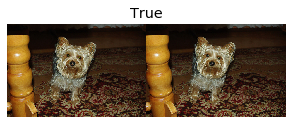

In [ ]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

In [ ]:
tst = ToTensor()(s)
tst.show();

All in one transform

In [ ]:
class SiamesePair(Transform):
    def __init__(self,items,labels):
        self.items,self.labels,self.assoc = items,labels,self
        sortlbl = sorted(enumerate(labels), key=itemgetter(1))
        # dict of (each unique label) -- (list of indices with that label)
        self.clsmap = {k:L(v).itemgot(0) for k,v in itertools.groupby(sortlbl, key=itemgetter(1))}
        self.idxs = range_of(self.items)
        
    def encodes(self,i):
        "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
        othercls = self.clsmap[self.labels[i]] if random.random()>0.5 else self.idxs
        otherit = random.choice(othercls)
        return SiameseImage(self.items[i], self.items[otherit], self.labels[otherit]==self.labels[i])

## Questionnaire

1. What is self-supervised learning?
1. What is a language model?
1. Why is a language model considered self-supervised learning?
1. What are self-supervised models usually used for?
1. What do we fine-tune language models?
1. What are the three steps to create a state-of-the-art text classifier?
1. How do the 50,000 unlabeled movie reviews help create a better text classifier for the IMDb dataset?
1. What are the three steps to prepare your data for a language model?
1. What is tokenization? Why do we need it?
1. Name three different approaches to tokenization.
1. What is 'xxbos'?
1. List 4 rules that fastai applies to text during tokenization.
1. Why are repeated characters replaced with a token showing the number of repetitions, and the character that's repeated?
1. What is numericalization?
1. Why might there be words that are replaced with the "unknown word" token?
1. With a batch size of 64, the first row of the tensor representing the first batch contains the first 64 tokens for the dataset. What does the second row of that tensor contain? What does the first row of the second batch contain? (Careful—students often get this one wrong! Be sure to check your answer against the book website.)
1. Why do we need padding for text classification? Why don't we need it for language modeling?
1. What does an embedding matrix for NLP contain? What is its shape?
1. What is perplexity?
1. Why do we have to pass the vocabulary of the language model to the classifier data block?
1. What is gradual unfreezing?
1. Why is text generation always likely to be ahead of automatic identification of machine generated texts?

### Further research

1. See what you can learn about language models and disinformation. What are the best language models today? Have a look at some of their outputs. Do you find them convincing? How could a bad actor best use this to create conflict and uncertainty?
1. Given the limitation that models are unlikely to be able to consistently recognise machine generated texts, what other approaches may be needed to handle large-scale disinformation campaigns that leveraged deep learning?

## Becoming a deep learning practitioner

Congratulations — you've completed all of the chapters in this book which cover the key practical parts of training and using deep learning! You know how to use all of fastai's built in applications, and how to customise them using the data blocks API and loss functions. You even know how to create a neural network from scratch, and train it! (And hopefully you now know some of the questions to ask to help make sure your creations help improve society too.)

The knowledge you already have is enough to create full working prototypes of many types of neural network application. More importantly, it will help you understand the capabilities and limitations of deep learning models, and how to design a system which best handles these capabilities and limitations.

In the rest of this book we will be pulling apart these applications, piece by piece, to understand all of the foundations they are built on. This is important knowledge for a deep learning practitioner, because it is the knowledge which allows you to inspect and debug models that you build, and to create new applications which are customised for your particular projects.